In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import torchtuples as tt
from pycox.models import CoxPH
from pycox.preprocessing.label_transforms import LabTransCoxTime
from pycox.evaluation import EvalSurv
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset


In [2]:
# 1) Load the data
betas = pd.read_csv("beta_values_filtered.csv", index_col=0)   # shape: (n_probes, n_samples)
meta  = pd.read_csv("beta_metadata_filtered.csv")             # shape: (n_samples, ...)


In [23]:
# 2) Transpose so rows = samples, cols = probes
X = betas.T.values    # now shape: (106, 866238)

# 3) Survival arrays
T = meta["Days"].values
E = meta["Status"].values

In [24]:
# 3) Split into train (70%) and test (30%) without stratification
X_train, X_test, T_train, T_test, E_train, E_test = train_test_split(
    X, T, E,
    test_size=0.30,
    random_state=42
)

print("Train samples:", X_train.shape[0], "Test samples:", X_test.shape[0])

Train samples: 74 Test samples: 32


In [25]:
# 5) Scale features on TRAIN only
scaler    = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)


In [26]:
# 6) PCA on TRAIN only (retain 95% variance), then transform TEST
pca        = PCA(n_components=0.95, svd_solver='full').fit(X_train_s)
X_train_p  = pca.transform(X_train_s)
X_test_p   = pca.transform(X_test_s)

print("After PCA: train shape =", X_train_p.shape, ", test shape =", X_test_p.shape)

After PCA: train shape = (74, 60) , test shape = (32, 60)


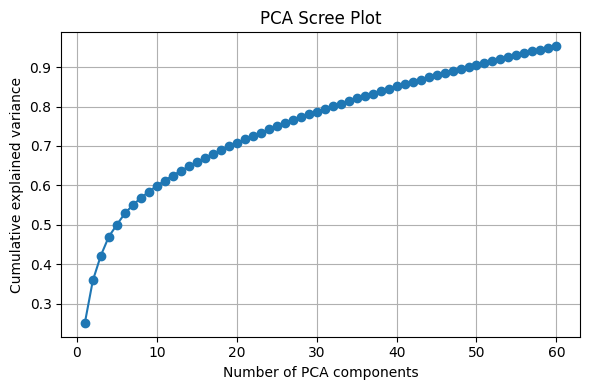

PCA scree plot saved to PCA_scree_plot.pdf


In [27]:
# 5a) Scree plot: use len(explained_variance_ratio_)
explained = pca.explained_variance_ratio_
cum_var    = np.cumsum(explained)
num_pcs    = len(explained)

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, num_pcs+1), cum_var, marker='o')
plt.xlabel("Number of PCA components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Scree Plot")
plt.grid(True)
plt.tight_layout()
plt.show()

pdf_path = "PCA_scree_plot.pdf"
plt.savefig(pdf_path)
plt.close()

print(f"PCA scree plot saved to {pdf_path}")

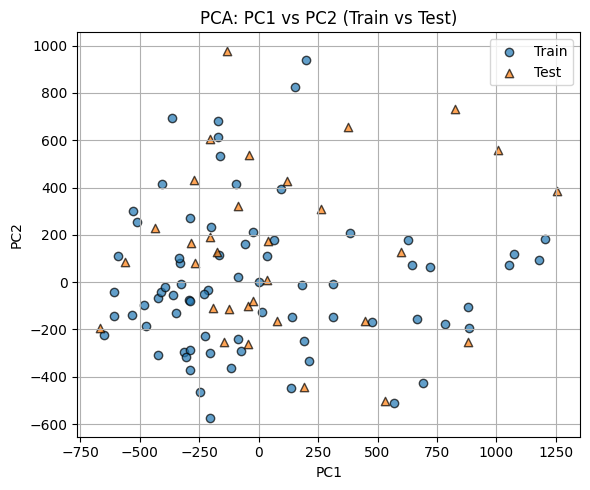

In [28]:
# 5b) PC1 vs PC2 scatter, colored by train/test
plt.figure(figsize=(6,5))
plt.scatter(X_train_p[:,0], X_train_p[:,1], label="Train", alpha=0.7, edgecolor='k')
plt.scatter(X_test_p[:,0],  X_test_p[:,1],  label="Test",  alpha=0.7, marker='^', edgecolor='k')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA: PC1 vs PC2 (Train vs Test)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("PCA_plot_PC1vsPC2.pdf")
plt.show()


In [29]:
# ───────────────────────────────────────────────────────────────
# 6) Prepare for DeepSurv (pycox)

# ─── 6) Label transform for CoxPH ───────────────────────────
labtrans = LabTransCoxTime()
y_train  = labtrans.fit_transform(T_train, E_train)
y_test   = labtrans.transform(T_test, E_test)

# ─── 7) Wrap as torch datasets ──────────────────────────────
train_ds = (X_train_p.astype("float32"), y_train)

In [36]:
import torchtuples as tt
from pycox.models import CoxPH

# number of inputs = number of PCA components
in_features  = X_train_p.shape[1]
hidden_nodes = [64, 32]
dropout_rate = 0.1
out_features = 1

# instantiate the network
net = tt.practical.MLPVanilla(
    in_features=in_features,
    num_nodes=hidden_nodes,
    out_features=out_features,     # <— this was missing
    dropout=dropout_rate,
    output_bias=False
)

# wrap in a CoxPH model
model = CoxPH(net, tt.optim.Adam)
model.optimizer.set_lr(5e-4)

# now train as before
callbacks = [tt.callbacks.EarlyStopping()]

_ = model.fit(
    X_train_p.astype("float32"), 
    y_train, 
    batch_size=16, 
    epochs=100,
    callbacks=callbacks,
    val_data=(X_test_p.astype("float32"), y_test),
    verbose=True
)


0:	[5s / 5s],		train_loss: 2.1524,	val_loss: 2.4481
1:	[3s / 9s],		train_loss: 2.0281,	val_loss: 2.3673
2:	[5s / 14s],		train_loss: 2.0635,	val_loss: 2.3173
3:	[0s / 14s],		train_loss: 1.9956,	val_loss: 2.3002
4:	[1s / 15s],		train_loss: 1.9716,	val_loss: 2.2982
5:	[0s / 16s],		train_loss: 1.8251,	val_loss: 2.2965
6:	[0s / 16s],		train_loss: 1.8804,	val_loss: 2.3019
7:	[0s / 16s],		train_loss: 1.9072,	val_loss: 2.2932
8:	[0s / 17s],		train_loss: 1.8406,	val_loss: 2.2989
9:	[0s / 17s],		train_loss: 1.9595,	val_loss: 2.2900
10:	[0s / 17s],		train_loss: 1.8667,	val_loss: 2.2818
11:	[0s / 17s],		train_loss: 1.7735,	val_loss: 2.2819
12:	[0s / 17s],		train_loss: 1.7776,	val_loss: 2.2738
13:	[0s / 17s],		train_loss: 1.7463,	val_loss: 2.2764
14:	[0s / 18s],		train_loss: 1.7741,	val_loss: 2.2770
15:	[1s / 20s],		train_loss: 1.7398,	val_loss: 2.2750
16:	[0s / 20s],		train_loss: 1.7212,	val_loss: 2.2774
17:	[0s / 20s],		train_loss: 1.6678,	val_loss: 2.2781
18:	[0s / 20s],		train_loss: 1.6385,	val

In [37]:
# After training completes, compute baseline hazards once:
model.compute_baseline_hazards()

# Now you can predict survival functions:
surv = model.predict_surv_df(X_test_p.astype("float32"))

# ...and continue with evaluation as before:
from pycox.evaluation import EvalSurv

ev = EvalSurv(surv, T_test, E_test, censor_surv='km')
c_index = ev.concordance_td("antolini")
print(f"Test time-dependent C-index: {c_index:.3f}")


Test time-dependent C-index: 0.716


Brier score @ 180 days: 0.971
Brier score @ 270 days: 0.900
Brier score @ 360 days: 0.863
Brier score @ 450 days: 0.742
Brier score @ 540 days: 0.550
Brier score @ 630 days: 0.381
Brier score @ 720 days: 0.381


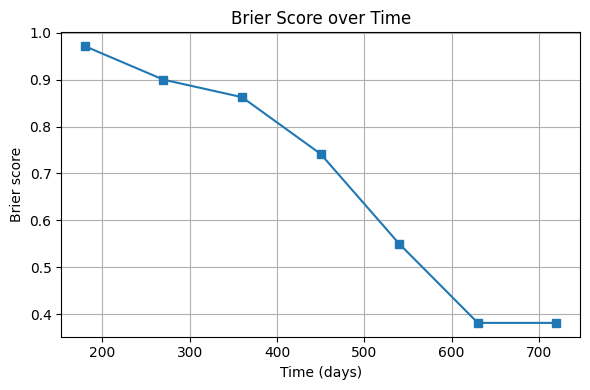

In [45]:
# 1) Choose the times at which you want Brier scores
# ─── 1) Brier score over time ────────────────────────────────
times_eval = np.arange(180, 731, 90)  # every 3 months from 6m to 2y
brier_scores = ev.brier_score(times_eval)

# Print
for t, bs in zip(times_eval, brier_scores):
    print(f"Brier score @ {t} days: {bs:.3f}")

# Plot & save
plt.figure(figsize=(6,4))
plt.plot(times_eval, brier_scores, marker='s')
plt.xlabel("Time (days)")
plt.ylabel("Brier score")
plt.title("Brier Score over Time")
plt.grid(True)
plt.tight_layout()
plt.savefig("brier_score_over_time.pdf")
plt.show()


In [46]:
# 2) Integrated Brier Score (0–730 days)
ibs = ev.integrated_brier_score(times)
print(f"Integrated Brier Score: {ibs:.3f}")


NameError: name 'times' is not defined

In [47]:
# ─── 2) Harrell’s C-index ────────────────────────────────────
ci_harrell = concordance_index(T_test, -risk_scores, E_test)
print(f"Harrell's C-index: {ci_harrell:.3f}")

NameError: name 'risk_scores' is not defined

In [48]:
# ─── 3) Landmark C-index (time-dependent discrimination) ────
# We can approximate AUC(t) by computing the C-index on the subset at risk at each t.
landmark_times = np.arange(180, 731, 90)
ci_landmark = []
for t in landmark_times:
    # select patients with T_test >= t (i.e. still at risk at t)
    at_risk = T_test >= t
    ci_t    = concordance_index(
        T_test[at_risk],      # times
        -risk_scores[at_risk],# predictions
        E_test[at_risk]       # events
    )
    ci_landmark.append(ci_t)
    print(f"C-index @ {t} days: {ci_t:.3f}")

# Plot landmark C-index
plt.figure(figsize=(6,4))
plt.plot(landmark_times, ci_landmark, marker='o')
plt.xlabel("Time (days)")
plt.ylabel("C-index")
plt.title("Landmark C-index over Time")
plt.grid(True)
plt.tight_layout()
plt.savefig("landmark_cindex_over_time.pdf")
plt.show()

NameError: name 'risk_scores' is not defined

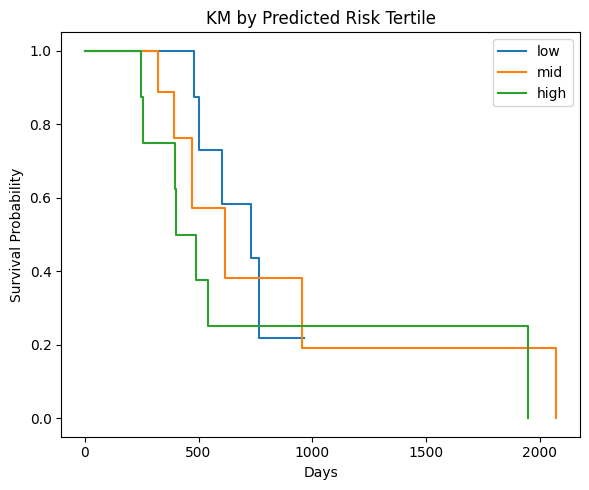

In [49]:
risk_scores = model.predict(X_test_p.astype("float32")).reshape(-1)
groups = pd.qcut(risk_scores, 3, labels=["low","mid","high"])

plt.figure(figsize=(6,5))
kmf = KaplanMeierFitter()
for g in ["low","mid","high"]:
    mask = groups == g
    kmf.fit(T_test[mask], E_test[mask], label=g)
    kmf.plot_survival_function(ci_show=False)
plt.title("KM by Predicted Risk Tertile")
plt.xlabel("Days")
plt.ylabel("Survival Probability")
plt.tight_layout()
plt.savefig("KM_by_Predicted_Risk_Tertile_PCA.pdf")
plt.show()

Using Variational AutoEncoder for this analysis

In [56]:
# ─── 1) Load & split ────────────────────────────────────────────────
betas = pd.read_csv("beta_values_filtered.csv", index_col=0).T.values
meta  = pd.read_csv("beta_metadata_filtered.csv")
T, E = meta["Days"].values, meta["Status"].values

X_train, X_test, T_train, T_test, E_train, E_test = train_test_split(
    betas, T, E, test_size=0.30, random_state=42
)

In [57]:
# 1) Standardize raw methylation data
scaler_raw = StandardScaler().fit(X_train)        # fit on train only
X_train_s   = scaler_raw.transform(X_train)
X_test_s    = scaler_raw.transform(X_test)

# 2) PCA on standardized data (retain 95% variance)
pca      = PCA(n_components=0.95, svd_solver="full").fit(X_train_s)
X_train_p = pca.transform(X_train_s)
X_test_p  = pca.transform(X_test_s)

In [58]:
# 3) (Optional) re‐scale PC scores before VAE
scaler_pcs = StandardScaler().fit(X_train_p)
X_train_p_s = scaler_pcs.transform(X_train_p)
X_test_p_s  = scaler_pcs.transform(X_test_p)

In [59]:
# 4) Define your VAE to work on these PC‐space inputs
latent_dim = 50
input_dim  = X_train_p_s.shape[1]

class SmallVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Linear(input_dim, 64)
        self.mu   = nn.Linear(64, latent_dim)
        self.logv = nn.Linear(64, latent_dim)
        self.dec1 = nn.Linear(latent_dim, 64)
        self.dec2 = nn.Linear(64, input_dim)
    def encode(self, x):
        h = torch.relu(self.enc1(x))
        return self.mu(h), self.logv(h)
    def reparam(self, m, lv):
        std = (0.5*lv).exp()
        eps = torch.randn_like(std)
        return m + eps*std
    def decode(self, z):
        h = torch.relu(self.dec1(z))
        return self.dec2(h)
    def forward(self, x):
        m, lv = self.encode(x)
        z = self.reparam(m, lv)
        return self.decode(z), m, lv

In [62]:
# Select GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 5) Train VAE on scaled‐then‐PCA data
vae       = SmallVAE().to(device)
optim_vae = optim.Adam(vae.parameters(), lr=1e-4)
recon_fn  = nn.MSELoss(reduction="mean")
beta      = 1e-3

def vae_loss(recon_x, x, m, lv):
    mse = recon_fn(recon_x, x)
    kld = -0.5 * torch.mean(1 + lv - m.pow(2) - lv.exp())
    return mse + beta*kld

train_ds = TensorDataset(
    torch.from_numpy(X_train_p_s).float(),
    torch.from_numpy(X_train_p_s).float()
)
loader = DataLoader(train_ds, batch_size=32, shuffle=True)

vae.train()
for epoch in range(30):
    total = 0
    for xb, _ in loader:
        xb = xb.to(device)
        optim_vae.zero_grad()
        recon, mu, logvar = vae(xb)
        loss = vae_loss(recon, xb, mu, logvar)
        loss.backward()
        optim_vae.step()
        total += loss.item()*xb.size(0)
    print(f"Epoch {epoch+1:02d} | VAE loss: {total/len(train_ds):.4f}")

Epoch 01 | VAE loss: 1.0781
Epoch 02 | VAE loss: 1.0645
Epoch 03 | VAE loss: 1.0577
Epoch 04 | VAE loss: 1.0802
Epoch 05 | VAE loss: 1.0705
Epoch 06 | VAE loss: 1.0555
Epoch 07 | VAE loss: 1.0650
Epoch 08 | VAE loss: 1.0529
Epoch 09 | VAE loss: 1.0608
Epoch 10 | VAE loss: 1.0612
Epoch 11 | VAE loss: 1.0582
Epoch 12 | VAE loss: 1.0548
Epoch 13 | VAE loss: 1.0489
Epoch 14 | VAE loss: 1.0569
Epoch 15 | VAE loss: 1.0690
Epoch 16 | VAE loss: 1.0494
Epoch 17 | VAE loss: 1.0474
Epoch 18 | VAE loss: 1.0576
Epoch 19 | VAE loss: 1.0405
Epoch 20 | VAE loss: 1.0593
Epoch 21 | VAE loss: 1.0447
Epoch 22 | VAE loss: 1.0609
Epoch 23 | VAE loss: 1.0514
Epoch 24 | VAE loss: 1.0508
Epoch 25 | VAE loss: 1.0465
Epoch 26 | VAE loss: 1.0556
Epoch 27 | VAE loss: 1.0430
Epoch 28 | VAE loss: 1.0423
Epoch 29 | VAE loss: 1.0547
Epoch 30 | VAE loss: 1.0377


In [64]:
vae.eval()
with torch.no_grad():
    xb = next(iter(loader))[0].to(device)
    recon, mu, logvar = vae(xb)
    mse = recon_fn(recon, xb).item()   # note recon_fn here
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp()).item()
print(f"Last epoch — MSE: {mse:.4f}, KL: {beta*kld:.4f}")


Last epoch — MSE: 1.0268, KL: 0.0000


In [77]:
# 1) Extract latent means for all samples
vae.eval()
with torch.no_grad():
    # train
    train_mu, _ = vae.encode(torch.from_numpy(X_train_p_s).float().to(device))
    Z_train = train_mu.cpu().numpy()
    # test
    test_mu, _ = vae.encode(torch.from_numpy(X_test_p_s).float().to(device))
    Z_test  = test_mu.cpu().numpy()

# 2) (Re)train DeepSurv on Z_train → Z_test
labtrans = LabTransCoxTime()
y_train  = labtrans.fit_transform(T_train, E_train)
y_test   = labtrans.transform(T_test,  E_test)

net = tt.practical.MLPVanilla(
    in_features=Z_train.shape[1],
    num_nodes=[64,32],
    out_features=1,
    dropout=0.1,
    output_bias=False
)
model = CoxPH(net, tt.optim.Adam)
model.optimizer.set_lr(1e-3)

_ = model.fit(
    Z_train.astype("float32"), y_train,
    batch_size=16, epochs=100,
    callbacks=[tt.callbacks.EarlyStopping()],
    val_data=(Z_test.astype("float32"), y_test),
    verbose=True
)
model.compute_baseline_hazards()

0:	[5s / 5s],		train_loss: 2.1758,	val_loss: 2.3157
1:	[5s / 10s],		train_loss: 2.0126,	val_loss: 2.3092
2:	[5s / 16s],		train_loss: 2.0197,	val_loss: 2.3011
3:	[5s / 21s],		train_loss: 1.9372,	val_loss: 2.2945
4:	[5s / 27s],		train_loss: 1.8625,	val_loss: 2.2871
5:	[5s / 32s],		train_loss: 1.8191,	val_loss: 2.2833
6:	[5s / 38s],		train_loss: 1.7942,	val_loss: 2.2759
7:	[5s / 43s],		train_loss: 1.7828,	val_loss: 2.2779
8:	[5s / 49s],		train_loss: 1.7166,	val_loss: 2.2793
9:	[5s / 54s],		train_loss: 1.7162,	val_loss: 2.2708
10:	[5s / 1m:0s],		train_loss: 1.6716,	val_loss: 2.2686
11:	[5s / 1m:5s],		train_loss: 1.5916,	val_loss: 2.2700
12:	[5s / 1m:11s],		train_loss: 1.6531,	val_loss: 2.2678
13:	[5s / 1m:16s],		train_loss: 1.5733,	val_loss: 2.2688
14:	[5s / 1m:22s],		train_loss: 1.5935,	val_loss: 2.2669
15:	[5s / 1m:27s],		train_loss: 1.6061,	val_loss: 2.2648
16:	[5s / 1m:33s],		train_loss: 1.5558,	val_loss: 2.2652
17:	[5s / 1m:38s],		train_loss: 1.4725,	val_loss: 2.2599
18:	[5s / 1m:44s]

duration
-0.850711    0.000000
-0.845340    0.000000
-0.838627    0.000000
-0.801030    0.000000
-0.763434    0.004931
               ...   
 1.268119    0.000000
 1.481614    0.000000
 1.666911    6.445605
 1.764930    7.812432
 6.907592    0.000000
Name: baseline_hazards, Length: 72, dtype: float32

Time-dependent C-index: 0.6855895196506551
Harrell's C-index: 0.6855895196506551


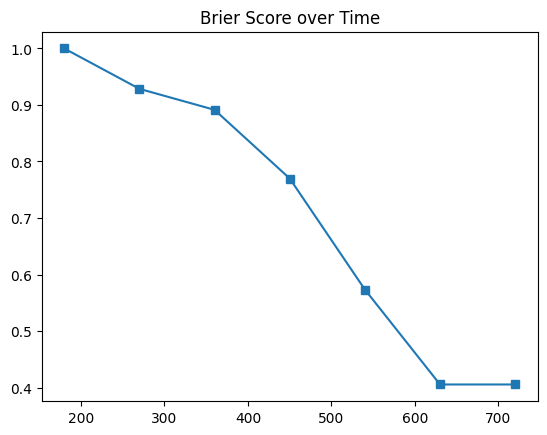

In [78]:
# 3) Evaluate with the same metrics
surv         = model.predict_surv_df(Z_test.astype("float32"))
risk_scores  = model.predict(Z_test.astype("float32")).reshape(-1)
ev           = EvalSurv(surv, T_test, E_test, censor_surv='km')

print("Time-dependent C-index:", ev.concordance_td("antolini"))
print("Harrell's C-index:", concordance_index(T_test, -risk_scores, E_test))

# Brier score
times_eval = np.arange(180, 731, 90)
brier_scores = ev.brier_score(times_eval)
plt.figure(); plt.plot(times_eval, brier_scores, marker='s'); 
plt.title("Brier Score over Time"); 
plt.show()


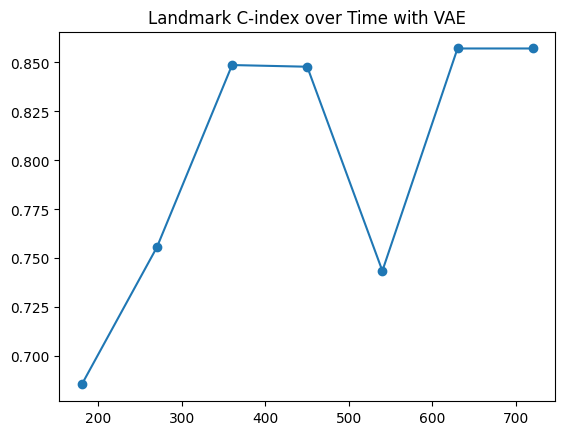

In [79]:
# Landmark C-index
ci_landmark = [
    concordance_index(T_test[T_test>=t], -risk_scores[T_test>=t], E_test[T_test>=t])
    for t in times_eval
]
plt.figure(); plt.plot(times_eval, ci_landmark, marker='o'); 
plt.title("Landmark C-index over Time with VAE")
plt.savefig("landmark_cindex_over_time_VAE.pdf")
plt.show()

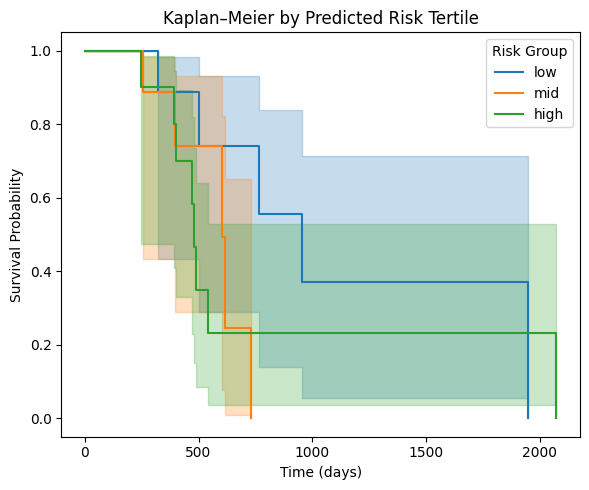

In [47]:
# 1) Bin patients into risk tertiles
groups = pd.qcut(risk_scores, 3, labels=["low","mid","high"])

# 2) Plot Kaplan–Meier curves for each tertile
plt.figure(figsize=(6,5))
kmf = KaplanMeierFitter()

for label in ["low", "mid", "high"]:
    mask = (groups == label)
    kmf.fit(durations=T_test[mask], event_observed=E_test[mask], label=label)
    kmf.plot_survival_function(ci_show=True)

plt.title("Kaplan–Meier by Predicted Risk Tertile")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.legend(title="Risk Group")
plt.tight_layout()

# 3) Save figure
plt.savefig("KM_by_risk_tertile.pdf")
plt.show()

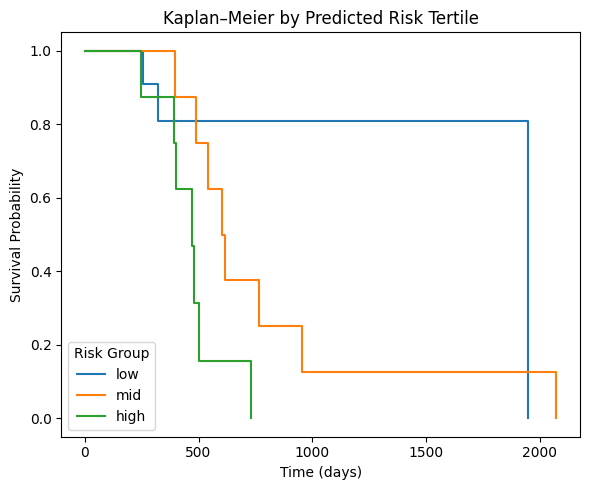

In [80]:
# 1) Bin into tertiles
groups = pd.qcut(risk_scores, 3, labels=["low","mid","high"])

# 2) Plot KM curves without the 95% CI
plt.figure(figsize=(6,5))
kmf = KaplanMeierFitter()

for label in ["low", "mid", "high"]:
    mask = (groups == label)
    kmf.fit(durations=T_test[mask],
            event_observed=E_test[mask],
            label=label)
    kmf.plot_survival_function(ci_show=False)   # turn off CI

plt.title("Kaplan–Meier by Predicted Risk Tertile")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.legend(title="Risk Group")
plt.tight_layout()
plt.savefig("KM_by_risk_tertile_noCI.pdf")
plt.show()